# Final - _Due Friday, October 21_
---
## Note: this is the final. It is _not_ a paired programming assignment. **You must complete this lab _on your own_**. 
---
### We'll be exploring the "Airplane Crashes Since 1908" dataset from [Kaggle](http://www.kaggle.com).
### Full history of airplane crashes throughout the world, from 1908-present.
The dataset was downloaded from https://www.kaggle.com/saurograndi/airplane-crashes-since-1908. 

After loading and cleaning the data:

+ **Hypothesis Testing** 
    
+ **Linear Regression**
    
+ **Time Series**

***
## Setup & clean the data
### First, load the packages that will be used in this notebook.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sqlalchemy import create_engine
from scipy import stats

random.seed(1234)
sns.set(font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


### Next, load the csv file into a DataFrame and look at the first few lines.

In [2]:
df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Here are the variable descriptions (not available in Kaggle website, but from my own understanding of the data):

|Variable|Description|
|:-:|:--|
|**Date**|Date of the accident|
|**Time**|Time of the accident|
|**Location**|Where the accident happened|
|**Operator**|The name of the airline having the accident|
|**Flight#**|The airline flight number|
|**Route**|The location where the flight was bounded|
|**Type**|The type of aircraft that had the accident|
|**Registration**|An alphanumeric string to identify the aircraft|
|**cn/ln**|Serial number of the aircraft|
|**Aboard**|Number of people that was on the aircraft|
|**Fatalities**|The number of fatalities of the total people aboard|
|**Ground**|The distance from the ground when the fatality happened|
|**Summary**|A free text field that summarizes and describes the accident|

Note that the field "Registration" should be unique (per NAA regulations), but after running a SQL query, we found duplicated records.

We can also modify the column names to get rid of periods and spaces. The column names should also be lowercased for use with SQLite.

In [3]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in df.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

df.columns = new_names

print(df.columns)

Index(['date', 'time', 'location', 'operator', 'flight#', 'route', 'type',
       'registration', 'cn/in', 'aboard', 'fatalities', 'ground', 'summary'],
      dtype='object')


In [4]:
df.count()

date            5268
time            3049
location        5248
operator        5250
flight#         1069
route           3562
type            5241
registration    4933
cn/in           4040
aboard          5246
fatalities      5256
ground          5246
summary         4878
dtype: int64

In [5]:
df.size

68484

In [6]:
df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,aboard,fatalities,ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,644.000000,583.000000,2750.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
date            5268 non-null object
time            3049 non-null object
location        5248 non-null object
operator        5250 non-null object
flight#         1069 non-null object
route           3562 non-null object
type            5241 non-null object
registration    4933 non-null object
cn/in           4040 non-null object
aboard          5246 non-null float64
fatalities      5256 non-null float64
ground          5246 non-null float64
summary         4878 non-null object
dtypes: float64(3), object(10)
memory usage: 535.1+ KB


We can see that the above numeric variables (aboard, fatalities, ground) have missing data (per NaN values), so will create a new dataset without missing values.

### Next, load the data into SQL

First we'll need to create a database, then create a table in our new database.

In [8]:
# Create air_crashes table in air_crashes database (only run this once!)
engine = create_engine('sqlite:///air_crashes.db')
conn = engine.connect()
df.to_sql('air_crashes', conn)

In [9]:
%load_ext sql

//anaconda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
//anaconda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [10]:
%sql sqlite:///air_crashes.db

'Connected: None@air_crashes.db'

In [11]:
%%sql
SELECT name FROM sqlite_master WHERE type = "table";

Done.


name
air_crashes


In [12]:
# Reload the data, but skip rows where type, location, aboard, fatalities, ground, date and time is NULL
df_not_null = %sql SELECT * FROM air_crashes WHERE type IS NOT NULL AND location IS NOT NULL AND aboard IS NOT NULL AND fatalities IS NOT NULL AND ground IS NOT NULL AND date IS NOT NULL AND time IS NOT NULL;
df = df_not_null.DataFrame()

Done.


In [13]:
# Date column is not datetime format, so we format it appropiately.
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 14 columns):
index           3042 non-null int64
date            3042 non-null datetime64[ns]
time            3042 non-null object
location        3042 non-null object
operator        3039 non-null object
flight#         996 non-null object
route           2566 non-null object
type            3042 non-null object
registration    2946 non-null object
cn/in           2440 non-null object
aboard          3042 non-null float64
fatalities      3042 non-null float64
ground          3042 non-null float64
summary         3026 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(9)
memory usage: 332.8+ KB


In [15]:
df.describe()

,index,aboard,fatalities,ground
count,3042.000000,3042.000000,3042.000000,3042.000000
mean,3032.580210,34.038133,24.760026,2.601907
std,1458.323473,51.708634,40.529903,70.833732
min,0.000000,0.000000,0.000000,0.000000
25%,1836.250000,5.000000,3.000000,0.000000
50%,3091.500000,16.000000,10.000000,0.000000
75%,4377.750000,39.000000,27.000000,0.000000
max,5266.000000,644.000000,583.000000,2750.000000


In [16]:
df.insert(1,'year', df['date'].apply(lambda x: x.year))
df.insert(2,'month', df['date'].apply(lambda x: x.month))
df.insert(3,'dayofweek', df['date'].apply(lambda x: x.dayofweek))
df.insert(4,'hour', df['time'].str[:2])

In [17]:
df.head()

,index,year,month,dayofweek,hour,date,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
0,0,1908,9,3,17,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,None,Demonstration,Wright Flyer III,None,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1,1912,7,4,06,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,None,Test flight,Dirigible,None,None,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,3,1913,9,1,18,1913-09-09,18:30,Over the North Sea,Military - German Navy,None,None,Zeppelin L-1 (airship),None,None,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
3,4,1913,10,4,10,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,None,None,Zeppelin L-2 (airship),None,None,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...
4,5,1915,3,4,01,1915-03-05,01:00,"Tienen, Belgium",Military - German Navy,None,None,Zeppelin L-8 (airship),None,None,41.0,21.0,0.0,Crashed into trees while attempting to land af...


## Hypothesis Testing

We will be using a significance level of 0.05

In [18]:
antonov_df = df[df['type'].str[:3] == ('Ant')]

In [19]:
airbus_df = df[df['type'].str[:6] == ('Airbus')]

In [20]:
boeing_df = df[df['type'].str[:6] == ('Boeing')]

#### The aircraft manufacturer Antonov claims the fatalities in their airplanes is less than 22 passengers.

We want to know if the number of fatalities is more than 22.

$H_0: \mu <= 22$

$H_a: \mu > 22$

$t_{stat} = \frac{\bar{X} - \mu_0}{s/ \sqrt{n}} $

In [21]:
t_stat_antonov = (antonov_df.fatalities.mean() - 22)/(antonov_df.fatalities.std()/len(antonov_df)**0.5)
t_stat_antonov

1.236639642819578

In [22]:
p_value_antonov = stats.t(len(antonov_df)-1).cdf(t_stat_antonov)
p_value_antonov

0.89053580997718673

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the fatalities in an aircraft manufactured by Antonov is more than 22.

A Type I error would be to claim that the Antonov aircraft have more than 22 fatalities, when they have less.

A Type II error would be to claim that the Antonov aircraft have less than 22 fatalities, when they have more.

#### The aircraft manufacturer Airbus claims the fatalities in their airplanes is less than 20%.

We want to know if the number of fatalities is more than 20%.

$H_0: p <= 20$%

$H_a: p > 20$%

In [23]:
percent_fatalities = airbus_df.fatalities/airbus_df.aboard

In [24]:
z_stat_airbus = (percent_fatalities.mean() - 0.20)/((0.20 * (1 - 0.20)/len(percent_fatalities)))**0.5
z_stat_airbus

6.022520746991066

In [25]:
p_value_airbus = stats.norm.cdf(z_stat_airbus)
p_value_airbus

0.99999999914139326

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the percentage of fatalities in an aircraft manufactured by Airbus is more than 20%.

A Type I error would be to claim that the Airbus aircraft have more than 20% fatalities, when they have less.

A Type II error would be to claim that the Airbys aircraft have less than 20% fatalities, when they have more.

In [34]:
boeing_average_fatalities = boeing_df.fatalities.mean()
boeing_std_deviation_fatalities = boeing_df.fatalities.std()
boeing_sample = len(boeing_df)
boeing_average_fatalities, boeing_std_deviation_fatalities, boeing_sample

(60.832752613240416, 75.68392066081435, 287)

#### Boeing claims that the average fatalities for their airplanes is more than 60. To test the claim, a random sample of 287 flights showed an average of 60.83 fatalities, with a standard deviation s of 75.68.  The FFA claims that average fatalities for Boeing is 70, what is the power of the test?

In [36]:
print("The power of the test is:",stats.t(287-1).cdf((boeing_average_fatalities - 70)/(boeing_std_deviation_fatalities /287**0.5)))

The power of the test is: 0.0205401984833


#### There's no difference in the number of fatalities for aircrafts Airbus and Boeing.

We want to know if they are different.

$H_0: \mu_1 = \mu_2 \text{ or } \mu_1 - \mu_2 = 0$  

$H_a: \mu_1 \neq \mu_2 \text{ or } \mu_1 - \mu_2 \neq 0$

In [26]:
stats.ttest_ind_from_stats(airbus_df.fatalities.mean(),airbus_df.fatalities.std(),airbus_df.fatalities.count(),boeing_df.fatalities.mean(),boeing_df.fatalities.std(),boeing_df.fatalities.count())

Ttest_indResult(statistic=2.2072303579014232, pvalue=0.028014126502163825)

The p-value is less than 0.05, therefore we reject the null hypothesis. There's enough evidence to conclude that the average fatalities for Airbus and Boeing is different.

### Are the fatalities independent of aircraft type Antonov, Airbus and Boeing?

$H_0$: fatalities are independent from aircraft type (Antonov, Airbus or Boeing).

$H_a$: fatalities are dependent from aircraft type (Antonov, Airbus or Boeing).

In [27]:
accidents_df = pd.DataFrame(index=['Fatalities'], columns=['Antonov','Airbus','Boeing'])
accidents_df.head()

,Antonov,Airbus,Boeing
Fatalities,NaN,NaN,NaN


In [28]:
accidents_df['Antonov'] = [antonov_df.fatalities.sum()]
accidents_df['Airbus'] = [airbus_df.fatalities.sum()]
accidents_df['Boeing'] = [boeing_df.fatalities.sum()]

In [29]:
accidents_df

,Antonov,Airbus,Boeing
Fatalities,2645.0,2971.0,17459.0


In [30]:
# In order to pass the dataframe data into stats.chisquare, IT NEEDS TO BE CONVERTED FROM PANDAS
# DATAFRAME INTO NUMPY ARRAY OR LIST.
fatalities_total_array = np.asarray(accidents_df.ix[0,:])
fatalities_total_array

array([  2645.,   2971.,  17459.])

In [31]:
expected_fatalities = [accidents_df.sum().sum()/3]*3
expected_fatalities

[7691.666666666667, 7691.666666666667, 7691.666666666667]

In [32]:
stats.chisquare(fatalities_total_array, expected_fatalities)

Power_divergenceResult(statistic=18611.61499458288, pvalue=0.0)

The p-value is less than 0.05, therefore we reject the null hypothesis that aircraft fatalities is independent from the aircraft type (Antonov, Airbus, Boeing).

## Linear Regression

#### Simple Regression

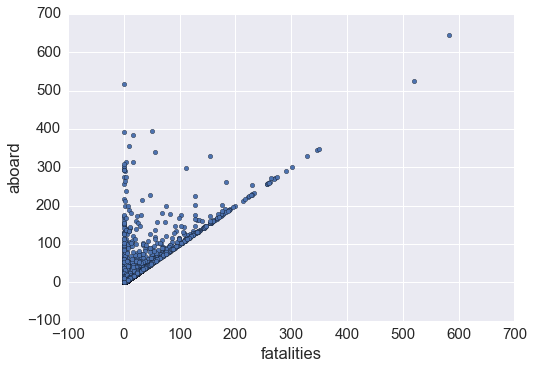

In [41]:
df.plot('fatalities', 'aboard', kind='scatter');

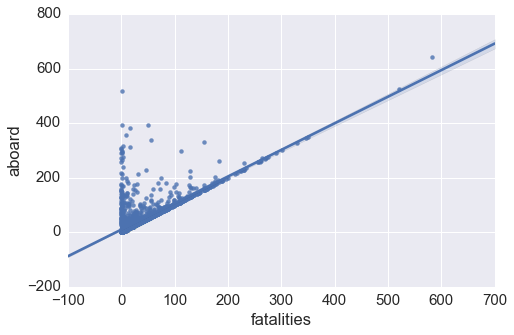

In [40]:
sns.lmplot(x='fatalities', y='aboard', data=df, aspect=1.5);

In [42]:
X_one = df.aboard
X_one = sm.add_constant(X_one)
y_one = df.fatalities

model_one = sm.OLS(y_one, X_one)
results_one = model_one.fit()
results_one.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     4264.
Date:                Wed, 05 Oct 2016   Prob (F-statistic):               0.00
Time:                        15:43:23   Log-Likelihood:                -14244.
No. Observations:                3042   AIC:                         2.849e+04
Df Residuals:                    3040   BIC:                         2.850e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.3750      0.568      7.707      0.000         3.262     5.488
aboard         0.5989      0.009     65.301      0.000         0.581     0.617
==============================================================================
Omnibus:                     1905.060   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90158.374
Skew:                          -2.321   Prob(JB):                         0.00
Kurtosis:                      29.263   Cond. No.                         74.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{fatalities} = 4.3750 + aboard * 0.5989$

#### Interpreting $R^2$:

The percentage of the variation in y (fatalities) can be explained by the corresponding variation in X (passengers aboard) and the least-squares line is 58.4%, and the unexplained percentage of variation is 100% – 58.4% = 41.6%.

#### Interpreting the model:

For every unit of increase of passengers aboard, fatalities increase by 0.5989.

#### Hypothesis testing:

Using a significance level of 0.05.

$H_0: \beta_1 = 0$

$H_a: \beta_1 \neq 0$

The F-statistic of the model is 4264 and the p-value is 0. 

Since the p-value is less than 0.05, so reject the null hypothesis and conclude that the coefficient of passengers aboard is significant.

#### Making a prediction of fatalities for all aircrafts with 2,000 passengers aboard:

In [73]:
results_one.predict([1, 2000])

array([ 1202.15277019])

#### The confidence interval for the above prediction is:

In [70]:
x = df.aboard
se = sqrt(results_one.mse_resid)
b0, b1 = results_one.params

x_new = 2000

def confidence_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

sign = array([-1., 1.])
b0 + b1 * x_new + sign * 1.96 * confidence_se(se, x, x_new)

array([ 1166.80145097,  1237.5040894 ])

#### The prediction interval for a particular aircraft with 2,000 passengers aboard:

In [71]:
def prediction_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1 + 1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

b0 + b1 * x_new + sign * 1.96 * prediction_se(se, x, x_new)

array([ 1139.88738854,  1264.41815183])

For both the given population of all aircrafts with passengers aboard of 2,000, the mean is the same as one aircraft with 2,000 passengers aboard. HOWEVER, the variance for the given population of all aircrafts with passengers aboard of 2,000 is $\sigma^2/n$, when the variance for the one aircraft with 2,000 passengers aboard is $\sigma^2$, which is more than the variance for the given population of all aircrafts with passengers aboard of 2,000. THEREFORE, the confidence interval for the given population of all aircrafts with passengers aboard of 2,000 is smaller than the prediction interval for the one aircraft with 2,000 passengers aboard.

#### Another way of constructing the linear model:

In [49]:
correlation = corrcoef(df.aboard,df.fatalities)

In [52]:
b_1 = correlation[0][1] * (df.fatalities.std()/df.aboard.std())
b_1

0.59888890193504241

In [53]:
b_0 = df.fatalities.mean() - b_1 * df.aboard.mean()
b_0

4.3749663175667237

$\hat{fatalities} = b_0 + b_1 * aboard$

#### Calculating residuals

In [66]:
# Function to calculate residuals:
def residuals(x,y):
    expected_list = []
    residuals = 0
    for i in range(len(x)):
        expected = b_0 + b_1 * i
        expected_list.append(expected)
    for j, s in zip(y,expected_list):
        residuals += (j - s)**2
    return residuals

In [67]:
# Function to calculate SSR:
def ssr(x,y):
    expected_list = []
    ssr = 0
    y_mean = sum(y)/len(y)
    for i in range(len(x)):
        expected = b_0 + b_1 * i
        expected_list.append(expected)
    for j in range(len(expected_list)):
        ssr += (j - y_mean)**2
    return ssr

In [68]:
print("Residuals:", residuals(df.aboard,df.fatalities))

Residuals: 3256095370.2


In [57]:
print("SSR:", ssr(df.aboard,df.fatalities))

SSR: 9151507126.180805


#### Multiple Regression

In [69]:
X_multi = df[['aboard','ground']]
X_multi = sm.add_constant(X_multi)
y_multi = df['fatalities']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     2134.
Date:                Wed, 05 Oct 2016   Prob (F-statistic):               0.00
Time:                        16:30:34   Log-Likelihood:                -14243.
No. Observations:                3042   AIC:                         2.849e+04
Df Residuals:                    3039   BIC:                         2.851e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.3586      0.568      7.678      0.000         3.246     5.472
aboard         0.5986      0.009     65.267      0.000         0.581     0.617
ground         0.0103      0.007      1.539      0.124        -0.003     0.023
==============================================================================
Omnibus:                     1902.204   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90171.217
Skew:                          -2.315   Prob(JB):                         0.00
Kurtosis:                      29.267   Cond. No.                         85.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{fatalities} = 4.3586 + aboard * 0.5986 + ground * 0.0103$

#### Interpretation of the overall F test:

F-statistic: 2134
Prob (F-statistic): 0

The overall model is good: the overall p-value is 0.0, which is less than 0.05. Also, the F-statistic is high (2134).

#### Model interpretation:

For every passenger aboard, fatalities increase by 0.5986.

For every feet above the ground, fatalities increase by 0.0103.

#### Interpreting $R^2$:

There's no difference with the model with just one variable.

HOWEVER, the F-statistic of the model with two indepedent variable is less than the model with just one independent variable. ALSO, the p-value of the model with two indepedent variable seems to be higher than the model with just one independent variable: the p-value for the independent variable ground is 0.124, which is greater than 0.05, and therefore it doesn't play a role in the model, so we should discard it.

The model with just one independent variable (passengers aboard) is the best one.